In [30]:
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pickle
from scipy.optimize import curve_fit
from scipy.stats import spearmanr
from sklearn.metrics import r2_score

sns.set(context='paper', 
        style='ticks', 
        font_scale=1,
        # add removing the right and top spines
        rc={'axes.spines.right': False, 
            'axes.spines.top': False,})

sns.set_palette('colorblind')

### 1. N-gram frequencies

In [15]:
def get_ngram(query, start_year=1800, end_year=2019, 
            corpus='en-2019'):
    url = f'https://books.google.com/ngrams/json?content={query}&year_start={start_year}&year_end={end_year}&corpus={corpus}&smoothing=0'
    response = requests.get(url)
    data = response.json() 
    return data[0]['timeseries'] if data else None

In [16]:
nouns = ['pitcher_NOUN', 'carafe_NOUN', 'flagon_NOUN', 'ever_NOUN', 'jug_NOUN']

In [17]:
frequencies = [get_ngram(noun, start_year=1900) for noun in nouns]
# convert frequncies to relative frequencies
# frequencies = [np.array(freq) / np.sum(freq) for freq in frequencies]
frequencies = np.array(frequencies)
# divide by sum of each column
frequencies = frequencies / np.sum(frequencies, axis=0)
colors = sns.color_palette("husl", len(nouns))

/var/folders/1c/pphtjl397rnbdcp94xmwzkqr0000gn/T/ipykernel_39293/280970720.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


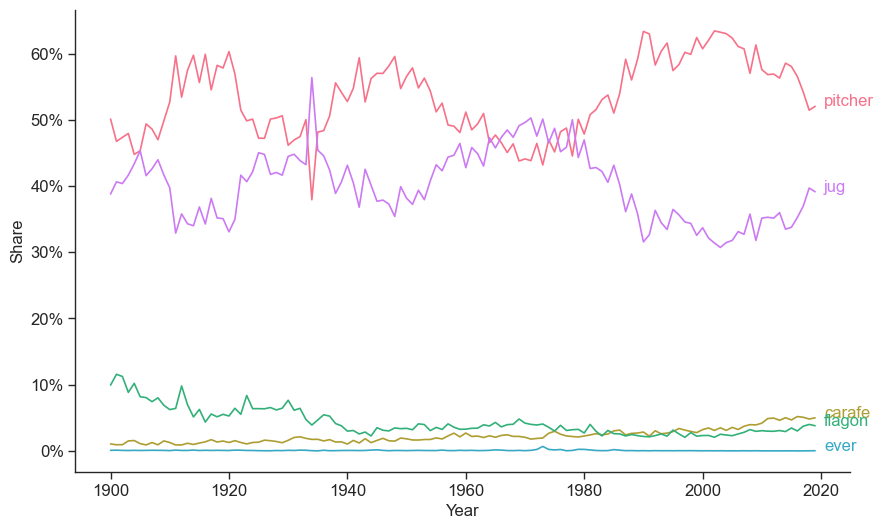

In [18]:
plt.figure(figsize=(10, 6))

for i, frequency in enumerate(frequencies):
    plt.plot(range(1900, 2020), frequency, color=colors[i])

# add labels at the end of the lines
for i, noun in enumerate(nouns):
    plt.text(2020.5, frequencies[i][-1], 
             noun.split('_')[0], color=colors[i], fontsize=12)
    
# convert y axis to percentage
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])

# increase text size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel('Year', fontsize=12)
plt.ylabel('Share', fontsize=12)
sns.despine()
plt.show()

### 2. ZLF in Slovotvir

In [14]:
def zipf_mandelbrot(x, P, V, B):
    return P / (x + V) ** B

In [10]:
true_likes = pickle.load(open("../data/true_likes.pkl", "rb"))

In [11]:
# create a true likes dataframe from a numpy array
true_likes_df = pd.DataFrame(true_likes, columns=['likes'])
# likes > 0
true_likes_df = true_likes_df[true_likes_df['likes'] > 0]

In [12]:
true_likes_df['part_1'] = true_likes_df['likes'].apply(lambda x: np.random.binomial(x, 0.5))
true_likes_df['part_2'] = true_likes_df['likes'] - true_likes_df['part_1']

# rank based on part_2, and compute frequency based on part_1
true_likes_df['rank'] = true_likes_df['part_2'].rank(ascending=False, method='first')
true_likes_df['frequency'] = true_likes_df['part_1'] / true_likes_df['part_1'].sum()

# get log
true_likes_df['log_freq'] = np.log(true_likes_df['frequency'])
# log rank
true_likes_df['log_rank'] = np.log(true_likes_df['rank'])

/opt/homebrew/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


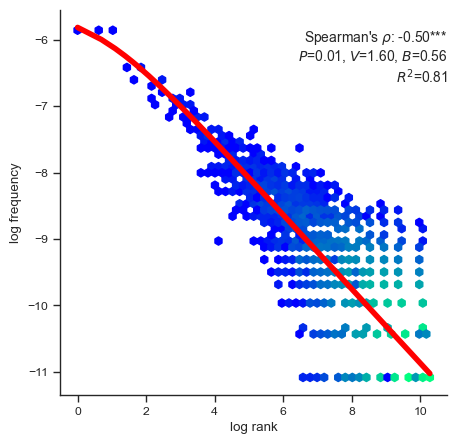

In [33]:
# plot frequency vs rank as a hexbin plot
plt.figure(figsize=(5, 5))
plt.hexbin(true_likes_df['log_rank'], true_likes_df['log_freq'], 
           gridsize=50, cmap='winter', bins='log')
# fit zipf mandelbrot
popt, pcov = curve_fit(zipf_mandelbrot, true_likes_df['rank'], true_likes_df['frequency'])
r2 = r2_score(true_likes_df['frequency'], zipf_mandelbrot(true_likes_df['rank'], *popt))
plt.plot(np.log(range(1, true_likes_df.shape[0] + 1)), 
         np.log(zipf_mandelbrot(range(1, true_likes_df.shape[0] + 1), *popt)), 
         color='red', lw=4)
corr, p_val = spearmanr(true_likes_df['log_rank'], true_likes_df['log_freq'])
stars = '***' if p_val < 0.001 else '**' if p_val < 0.01 else '*' if p_val < 0.05 else ''
plt.annotate(fr"Spearman's $\rho$: {corr:.2f}{stars}",
            xy=(1, 0.95), 
            xycoords='axes fraction', 
            ha='right', 
            va='top',
            fontsize=10)
plt.annotate(fr"$P$={popt[0]:.2f}, $V$={popt[1]:.2f}, $B$={popt[2]:.2f}",
            xy=(1, 0.9), 
            xycoords='axes fraction', 
            ha='right', 
            va='top',
            fontsize=10)
# add R^2 value
plt.annotate(fr"$R^2$={r2:.2f}",
            xy=(1, 0.85), 
            xycoords='axes fraction', 
            ha='right', 
            va='top',
            fontsize=10)
plt.xlabel('log rank')
plt.ylabel('log frequency')
plt.show()